In [1]:
model_paths = '../output/innately-local-models/relog-elliptical-maxout_4-max_fit_l1*.pkl'

In [2]:
import sys
sys.path.append('..')

In [52]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax
import os
from glob import glob
import pandas as pd
from tqdm import tqdm

In [4]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [36]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=False,
            transform=torchvision.transforms.ToTensor(), 
        )
loader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)
x, y = next(iter(loader))

In [38]:
from train import cifar_stats

# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

softmax_dim1 = lambda x: softmax(x, dim=1)

def denormalize_cifar_images(batch):
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return batch * stds + means

class Plotter(object):

    def __init__(self, idx=None, is_cifar=False):
        self.is_cifar = is_cifar
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        if is_cifar:
            sample2 = torch.randn(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k
        else:
            sample2 = torch.rand(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        if self.xs.shape[1] == 1: # black-and-white
            xs_vals = self.xs[:,0,:,:].numpy()
        elif self.xs.shape[1] == 3: # R-G-B
            if self.is_cifar:
                images = denormalize_cifar_images(self.xs)
            else:
                images = self.xs
            xs_vals = images.permute(0,2,3,1).numpy()
        else:
            raise ValueError('Unsupported image format')
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        ax[0].imshow(xs_vals[0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100])
        ax[4].set_title('Noise level: 100%')

    def plot_predictions(self, model, name, normalize_func=softmax_dim1):
        model.eval()
        preds, _ = model(self.xs)
        if normalize_func is not None:
            preds = normalize_func(preds)
        c0, c1 = preds[0].argsort(descending=True)[:2]
        pred_on_noise = preds[-1].clone()
        pred_on_noise[c0] = pred_on_noise[c1] = -np.inf # ignore the classes we have chosen already
        c2, c3 = pred_on_noise.argsort(descending=True)[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            c = c.item()
            plt.plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %d' %(c))
        plt.title('Model: ' + name)
        plt.legend()

In [39]:
model = load_model(glob(model_paths)[0])

In [40]:
p = Plotter(84)

Plotting image at index 84


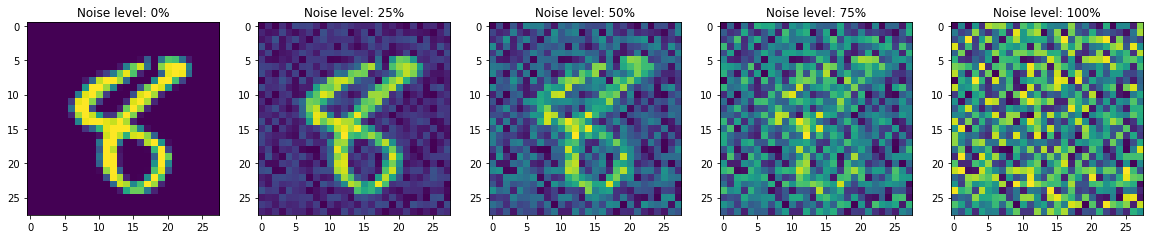

In [41]:
p.plot_transition()

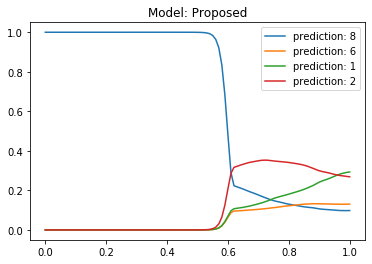

In [42]:
p.plot_predictions(model, 'Proposed')

In [14]:
p = Plotter(41)

Plotting image at index 41


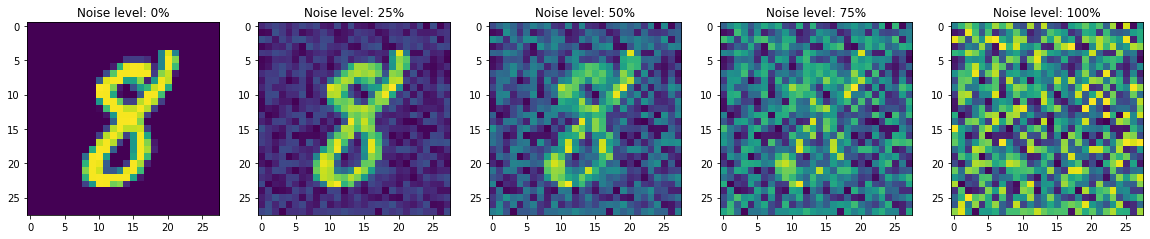

In [15]:
p.plot_transition()

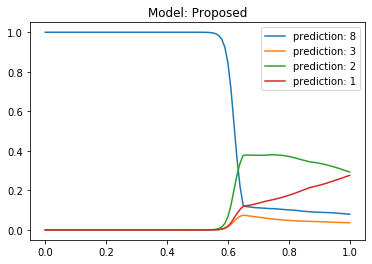

In [16]:
p.plot_predictions(model, 'Proposed')

In [17]:
p = Plotter(8)

Plotting image at index 8


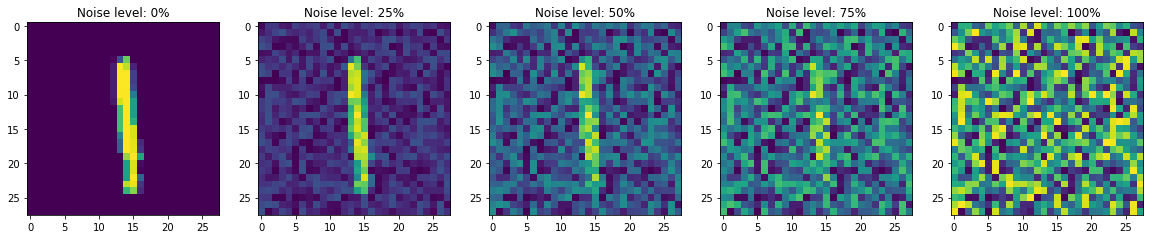

In [18]:
p.plot_transition()

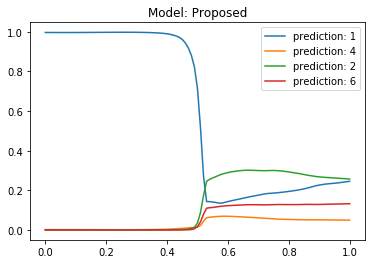

In [19]:
p.plot_predictions(model, 'Proposed')

Plotting image at index 2978


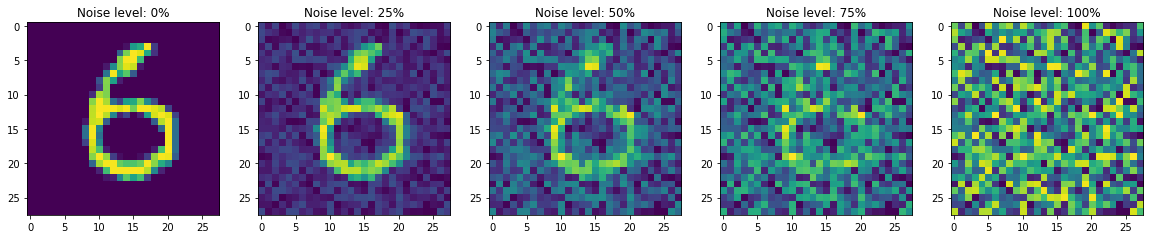

In [20]:
p = Plotter(2978)
p.plot_transition()

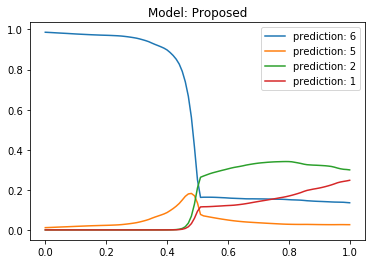

In [21]:
p.plot_predictions(model, 'Proposed')

# Classifying rubbish class examples

In [54]:
def evaluate(model):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)
    x, y = next(iter(loader))
    preds_on_true_images, _ = model(x)
    max_probs_on_true_images, predicted_classes = \
            softmax(preds_on_true_images, dim=1).max(dim=1)
    accuracy_on_true_images = (predicted_classes == y).float().mean().item()
    
    noise_images = torch.rand(*x.shape)
    preds, _ = model(noise_images)
    max_probs, _ = softmax(preds, dim=1).max(dim=1)
    accuracy_on_noise = (max_probs < 0.5).float().mean().item()
    return {
        'accuracy_on_true_images': accuracy_on_true_images,
        'prob_on_true_images': max_probs_on_true_images.mean().item(),
        'accuracy_on_noise': accuracy_on_noise,
        'prob_on_noise': max_probs.mean().item()
    }

In [55]:
results = []
with tqdm(glob(model_paths)) as progress:
    for path in progress:
        row = evaluate(load_model(path))
        row['path'] = path
        results.append(row)


100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


In [56]:
results = pd.DataFrame(results)

In [59]:
results.drop(columns='path').agg(['mean', 'std']).round(2)

,accuracy_on_true_images,prob_on_true_images,accuracy_on_noise,prob_on_noise
mean,0.99,0.98,0.81,0.35
std,0.00,0.00,0.31,0.19
